# Concrete Image Classification
By: Anthony Sheu

This project uses a 50/50 split dataset of positive (with cracks) and negative (without cracks) images of concrete. The data was obtained from https://data.mendeley.com/datasets/5y9wdsg2zt/2.

This binary classification model aims to be able to guess whether a provided image is positive or negative. Firstly, the images are randomly put in a 80% training, 20% validation split. Then the images will be pre-processed using transformations and finally fed through a pre-built CNN network with transfer learning to only modify the last layer (ResNet-18). The libraries used in this project are Pytorch (for deep learningm models) and torchvision (for transformations, training, and inferencing). The metrics will be tracked using WANDB and further analyzed.

In [2]:
%pip install -q matplotlib wandb scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -q pytorch_lightning

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install -q torch torchvision --index-url https://download.pytorch.org/whl/cu118

Note: you may need to restart the kernel to use updated packages.


## Example Images
Below is an image of a NEGATIVE (left) and POSITIVE (right) concrete crack.

In [78]:
from IPython.display import display, HTML

display(HTML(
"""
    <div style="display: flex; gap: 20px; text-align: center;">
    <div>
        <img src="samples/negative.jpg" width="300"><br>
        <strong>Negative</strong>
    </div>
    <div>
        <img src="samples/positive.jpg" width="300"><br>
        <strong>Positive</strong>
    </div>
    </div>
"""
))

## Image Augmentation
Now the data will be augmented with normalizations, resizing, etc. The reason is to expand the diversity of the training set and to ensure that my model is generalizeable over variations of data. It also helps simulate real-world variations such as different lighting, different colours, various positions, and noise/blur. 
Since I will be using the pre-trained ResNet-18 model, the images will be resized to 224 x 224 pixels. The reason is because ResNet-18 was originally trained on ImageNet where the images were resizd to 224 x 224. Then normalization values will be mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225], as these were the values used in training.

Information from https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html

A very basic transformation would look as follows.

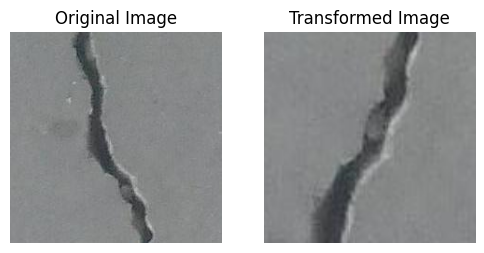

In [1]:
import matplotlib.pyplot as plt
import torchvision.transforms as tf
from PIL import Image

def showTransform():
    image_path = "samples/positive.jpg"
    image = Image.open(image_path)

    # original image
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    transformed_image = transform(image)
    transformed_image = transformed_image.permute(1, 2, 0) 
    transformed_image = transformed_image.numpy()

    # transformed image
    plt.subplot(1, 2, 2)
    plt.imshow(transformed_image)
    plt.title("Transformed Image")
    plt.axis("off")
    plt.show()



# transformations
transform = tf.Compose([
    tf.RandomResizedCrop(size = (224, 224), antialias=True),
    tf.RandomHorizontalFlip(),  
    tf.RandomVerticalFlip(),
    tf.ToTensor(),              
    # tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
showTransform()

Now we can experiment with other types of transformations such as random erasing, Gaussian blur, and random rotations.

### Random Erasing

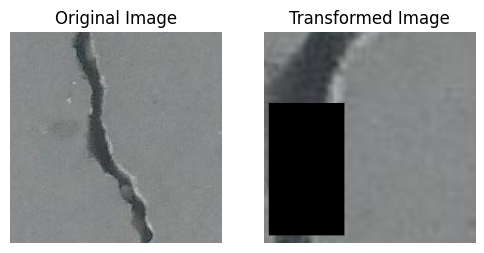

In [14]:
# transformations
transform = tf.Compose([
    tf.RandomResizedCrop(size = (224, 224), antialias=True),
    tf.RandomHorizontalFlip(),  
    tf.RandomVerticalFlip(),
    tf.ToTensor(),              
    # tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    tf.RandomErasing(p = 0.5, scale = (0.02, 0.25)),
])

showTransform()

https://docs.pytorch.org/vision/main/generated/torchvision.transforms.v2.RandomErasing.html#torchvision.transforms.v2.RandomErasing

### Gaussian Blur

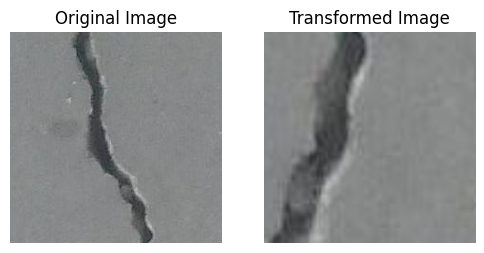

In [8]:
# transformations
transform = tf.Compose([
    tf.RandomResizedCrop(size = (224, 224), antialias=True),
    tf.RandomHorizontalFlip(),  
    tf.RandomVerticalFlip(),
    tf.GaussianBlur(kernel_size = (5, 5), sigma = (0.1, 2)),
    tf.ToTensor(),              
    # tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

showTransform()

https://docs.pytorch.org/vision/main/generated/torchvision.transforms.v2.GaussianBlur.html#torchvision.transforms.v2.GaussianBlur

### Random Rotation

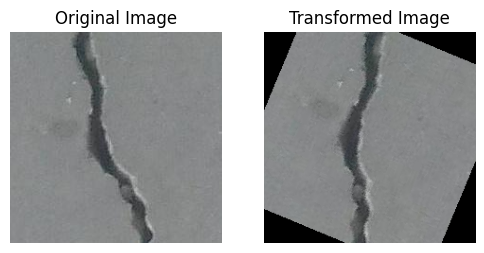

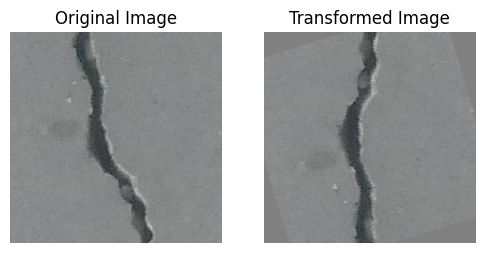

In [60]:
# transformations
transform = tf.Compose([
    tf.RandomRotation(degrees = (-30, 30)),
    tf.CenterCrop(224),
    tf.RandomHorizontalFlip(),  
    tf.RandomVerticalFlip(),
    tf.ToTensor(),              
    # tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

showTransform()

# transformations
transform = tf.Compose([
    tf.RandomRotation(degrees = (-30, 30), expand = False, fill = (128, 128, 128)),
    tf.CenterCrop(224),
    tf.RandomHorizontalFlip(),  
    tf.RandomVerticalFlip(),
    tf.ToTensor(),              
    # tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

showTransform()

When using random rotation, an issue came up where the rotation would cause parts of the image to be filled in with black pixels. This is because the square image rotated in any direction would cause it to essentially not be a square anymore (from the same perspective). I resorted to adding in filler grey pixels and only cropping from the center to minimize the amount of filler space and maximize the amount of actual data area.
https://docs.pytorch.org/vision/main/generated/torchvision.transforms.v2.RandomRotation.html#torchvision.transforms.v2.RandomRotation

### Final Transformations
My final verdict on which transformations to use to train the model is to try them all. I will be using 

1. Basic normal transformations
2. Random Erasing
3. Gaussian Blur
4. Random Rotation
5. Everything all at once

and comparing the metrics between each. These transformtions are just the ones from this list (https://docs.pytorch.org/vision/main/transforms.html) that seemed the most effective at creating variation in the training set to me.

## Creating the Model
Since I will be using a pre-trained model, I just have to make sure that I freeze all the previous layers and only train the last layer to perform transfer learning (and to save time). Then the metrics will be collected as it runs and displayed in wandb. The code is displayed below.

In [12]:
import torch
import torchvision.models
import torch.nn.functional as F
import pytorch_lightning as pl
from torchmetrics import Accuracy, Precision, Recall

class NeuralNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18(pretrained = True)

        # freeze pre-trained layers
        for param in self.model.parameters():
            param.requires_grad = False

        self.model.layer1.eval()
        self.model.layer2.eval()
        self.model.layer3.eval()
        self.model.layer4.eval()
        self.model.bn1.eval()

        num_ftrs = self.model.fc.in_features
        self.model.fc = torch.nn.Linear(num_ftrs, 2)

        # unfreeze final classification layer
        for param in self.model.fc.parameters():
            param.requires_grad = True

        # metrics
        self.accuracy = Accuracy(task="multiclass", num_classes=2)
        self.precision = Precision(task="multiclass", num_classes=2, average="macro")
        self.recall = Recall(task="multiclass", num_classes=2, average="macro")

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)

        self.log("val_loss", loss)
        self.log("val_acc", self.accuracy(preds, y))
        self.log("val_precision", self.precision(preds, y))
        self.log("val_recall", self.recall(preds, y))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = 1e-3)

## Loading data
The class below is responsible for loading the data and supplying the correct transformation for each of the 5 test cases. "transform" will be a global variable that we can just specify each time before we run it. The validation data set will not having any transformations performed on it. This is to combat the model from finding shortcuts by learning the transformations instead of classifying the images themselves.

In [13]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os

class Data(pl.LightningDataModule):
    def __init__(self, dir="data", size = 32):
        super().__init__()
        self.data_dir = dir
        self.batch_size = size
        self.transform = transform
    
    def setup(self, stage=None):
        self.train_data = ImageFolder(os.path.join(self.data_dir, 'train'), transform = self.transform)
        valt = tf.Compose([
            tf.Resize((224, 224)), 
            tf.ToTensor(),
            tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.val_data = ImageFolder(os.path.join(self.data_dir, 'val'), transform = valt)
    
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size = self.batch_size, num_workers = 6, pin_memory = True, shuffle = True, persistent_workers = True)
    
    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size = self.batch_size, num_workers = 6, pin_memory = True, persistent_workers = True)


## Testing with Basic Transformations
The first test will be using basic transformations: random resized crop, random horizontal flip, random vertical flip.

In [7]:
from pytorch_lightning.loggers import WandbLogger
import wandb

transform = tf.Compose([
    tf.RandomResizedCrop(size = (224, 224), antialias=True),
    tf.RandomHorizontalFlip(),  
    tf.RandomVerticalFlip(),
    tf.ToTensor(),              
    tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

model = NeuralNet()
data_module = Data()
wandb_logger = WandbLogger(project = "anomaly-detection", name = "basic transformations 2")
trainer = pl.Trainer(max_epochs = 5, logger = wandb_logger, devices = 1, accelerator = "gpu")
trainer.fit(model, data_module)
wandb.finish()

c:\Users\antho\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\antho\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, usin

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | ResNet              | 11.2 M | train
1 | accuracy  | MulticlassAccuracy  | 0      | train
2 | precision | MulticlassPrecision | 0      | train
3 | recall    | MulticlassRecall    | 0      | train
----------------------------------------------------------
1.0 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)
9         Modules in train mode
62        Modules in eval mode


Epoch 4: 100%|██████████| 1000/1000 [00:28<00:00, 34.68it/s, v_num=zjuu]   

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1000/1000 [00:29<00:00, 34.47it/s, v_num=zjuu]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆█████
train_loss,██▇▆▃▄▂▄▄▃▂▃▃▂▅▂▃▂▂▃▂▁▃▂▁▅▃▂▂▁▁▃▁▂▂▂▅▂▄▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
val_acc,▁▃▆▇█
val_loss,█▄▂▂▁
val_precision,▁▂▅▇█
val_recall,▁▂▅▇█
epoch,4
train_loss,0.0575
trainer/global_step,4999
val_acc,0.99625


## Testing with Random Erasing

In [73]:
transform = tf.Compose([
    tf.RandomResizedCrop(size = (224, 224), antialias=True),
    tf.ToTensor(),              
    tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    tf.RandomErasing(p = 0.5, scale = (0.02, 0.25)),
])

model = NeuralNet()
data_module = Data()
wandb_logger = WandbLogger(project = "anomaly-detection", name = "random erase")
trainer = pl.Trainer(max_epochs = 5, logger = wandb_logger, devices = 1, accelerator = "gpu")
trainer.fit(model, data_module)
wandb.finish()

c:\Users\antho\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\antho\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, usin

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | ResNet              | 11.2 M | train
1 | accuracy  | MulticlassAccuracy  | 0      | train
2 | precision | MulticlassPrecision | 0      | train
3 | recall    | MulticlassRecall    | 0      | train
----------------------------------------------------------
1.0 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)
9         Modules in train mode
62        Modules in eval mode


Epoch 4: 100%|██████████| 1000/1000 [00:33<00:00, 29.53it/s, v_num=l2mw]   

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1000/1000 [00:34<00:00, 29.32it/s, v_num=l2mw]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆████████
train_loss,▄▃▄▄▂▂▁▃▂▂▄▃▃▁▃▅▄▂▂▂█▂▁▅▁▂▂▄▃▃▂▂▆▁█▁▃▂▂▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
val_acc,▁▄▅██
val_loss,█▄▃▁▁
val_precision,▁▃▅██
val_recall,▁▄▅██
epoch,4
train_loss,0.07584
trainer/global_step,4999
val_acc,0.998


## Testing with Gaussian Blur

In [74]:
transform = tf.Compose([
    tf.RandomResizedCrop(size = (224, 224), antialias=True),
    tf.GaussianBlur(kernel_size = (5, 5), sigma = (0.1, 2)),
    tf.ToTensor(),              
    tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

model = NeuralNet()
data_module = Data()
wandb_logger = WandbLogger(project = "anomaly-detection", name = "gaussian blur")
trainer = pl.Trainer(max_epochs = 5, logger = wandb_logger, devices = 1, accelerator = "gpu")
trainer.fit(model, data_module)
wandb.finish()

c:\Users\antho\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\antho\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, usin

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | ResNet              | 11.2 M | train
1 | accuracy  | MulticlassAccuracy  | 0      | train
2 | precision | MulticlassPrecision | 0      | train
3 | recall    | MulticlassRecall    | 0      | train
----------------------------------------------------------
1.0 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)
9         Modules in train mode
62        Modules in eval mode


Epoch 4: 100%|██████████| 1000/1000 [00:56<00:00, 17.72it/s, v_num=9cna]   

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1000/1000 [00:56<00:00, 17.66it/s, v_num=9cna]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆████████
train_loss,▃▂▁▆▂█▇▃▃▅▃▃▂▁▁▃▁▃▃▂▁▂▂▁▂▁▃▁▂▂▂▁▃█▁▁▅▂▃▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
val_acc,▁▇█▆█
val_loss,█▄▂▁▂
val_precision,▁▇█▆█
val_recall,▁▇█▆█
epoch,4
train_loss,0.05633
trainer/global_step,4999
val_acc,0.99837


## Testing with Random Rotation and Filling

In [90]:
transform = tf.Compose([
    tf.RandomRotation(degrees = (-89, 89), expand = False, fill = (128, 128, 128)),
    tf.CenterCrop(224),
    tf.ToTensor(),              
    tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

model = NeuralNet()
data_module = Data()
wandb_logger = WandbLogger(project = "anomaly-detection", name = "random rotation")
trainer = pl.Trainer(max_epochs = 5, logger = wandb_logger, devices = 1, accelerator = "gpu")
trainer.fit(model, data_module)
wandb.finish()

c:\Users\antho\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\antho\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, usin

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | ResNet              | 11.2 M | train
1 | accuracy  | MulticlassAccuracy  | 0      | train
2 | precision | MulticlassPrecision | 0      | train
3 | recall    | MulticlassRecall    | 0      | train
----------------------------------------------------------
1.0 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)
9         Modules in train mode
62        Modules in eval mode


Epoch 4: 100%|██████████| 1000/1000 [00:39<00:00, 25.44it/s, v_num=kg34]   

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1000/1000 [00:39<00:00, 25.30it/s, v_num=kg34]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆██████████
train_loss,█▄▃▃▁▂▁▁▁▁▂▂▁▁▁▁▂▁▁▂▂▁▁▂▁▁▁▂▁▃▁▁▁▁▁▁▁▁▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
val_acc,▁▅▆▇█
val_loss,█▄▂▂▁
val_precision,▁▅▆▇█
val_recall,▁▅▆▇█
epoch,4
train_loss,0.00082
trainer/global_step,4999
val_acc,0.99787


## Testing with All Transformations

In [91]:
transform = tf.Compose([
    tf.RandomRotation(degrees = (-89, 89), expand = False, fill = (128, 128, 128)),
    tf.CenterCrop(224),
    tf.RandomHorizontalFlip(),  
    tf.RandomVerticalFlip(),
    tf.GaussianBlur(kernel_size = (5, 5), sigma = (0.1, 2)),
    tf.ToTensor(),              
    tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    tf.RandomErasing(p = 0.5, scale = (0.02, 0.25)),
])

model = NeuralNet()
data_module = Data()
wandb_logger = WandbLogger(project = "anomaly-detection", name = "everything")
trainer = pl.Trainer(max_epochs = 5, logger = wandb_logger, devices = 1, accelerator = "gpu")
trainer.fit(model, data_module)
wandb.finish()

c:\Users\antho\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\antho\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, usin

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | ResNet              | 11.2 M | train
1 | accuracy  | MulticlassAccuracy  | 0      | train
2 | precision | MulticlassPrecision | 0      | train
3 | recall    | MulticlassRecall    | 0      | train
----------------------------------------------------------
1.0 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)
9         Modules in train mode
62        Modules in eval mode


Epoch 4: 100%|██████████| 1000/1000 [01:09<00:00, 14.45it/s, v_num=9sj2]   

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1000/1000 [01:09<00:00, 14.40it/s, v_num=9sj2]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆███████
train_loss,▄▂▂▂▂▂▂█▂▂▁▁▅▁▂▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▂▃▃▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
val_acc,▁▇▆▆█
val_loss,█▃▂▂▁
val_precision,▁▇▆▆█
val_recall,▁▇▆▆█
epoch,4
train_loss,0.00063
trainer/global_step,4999
val_acc,0.99713


## Results
The metrics tracked were 

1. val_loss (how well the model performs on unseen/testing data)
2. val_acc (validation accuracy % of correct predictions)
3. train_loss (how well the model is performing on the training dataset)
4. precision (quantifies how many of the positive predictions were actually positive)
5. recall (quantifies how many of the positive observations were identified as positive)

### Basic Transformations
The metrics we obtained are 

1. val_loss = 0.98137
2. val_precision = 0.982
3. val_loss = 0.00677
4. val_acc = 0.99875

First let's take a look at the accuracy: a whopping 99%. This means that our model is performing exceptionally well on the validation data. To see whether our model is overfitting, we check to see if the training loss goes down while validation loss increases and validation accuracy plateaus/decreases. In the chart, we can see that this is not the case. While the 99% accuracy is suspicious, there might be other factors to analyze. One possible case is that the validation set is too easy (all the images are very similar). We have pretty high values of precision and recall as well, both around 98%. 


In [88]:
from IPython.display import display, HTML

display(HTML("""
    <img src="samples/basic.jpg">
"""))

### Comparing Other Transformations
When we compare the metrics of all other transformations, we find one singular answer: basic transformations performs better. Not only just the highest accuracy, but also the highest recall and precision, lowest validation loss, and least noisy training loss. When I first saw these results, I was very confused: shouldn't more transformations generalize the model better? Shouldn't the model be able to predict better with more augmentations? Upon seeing the metrics, I realized I had the whole thing mixed up. Simpler augmentations are more likely to simluate real-world conditions than let's say randomly erasing a patch of image. This rules out random erase as it has a high chance of erasing critical parts. I believe the reason random rotation does not perform as well is because upon rotating the image, it creates empty triangular regions which I filled in with grey pixels. This can cause confusion for the model as it essentially shouldn't exist. Gaussian blur gives us the best metrics out of the three as it is the least aggressive augmentation. This is why we see the metrics for the test with all transformations is the worst as it's too aggressive.

In [93]:
from IPython.display import display, HTML

display(HTML("""
    <img src="samples/chart.jpg">
"""))

## Further Testing
Now with our results from using different transformations, I will be trying basic transformations with Gaussian blur to see how well that performs compared to basic transformations. As well, I will increase the number of epochs from 5 -> 20 just to see if allowing the model to train over the training dataset 15 more times will cause it to fit better.

### Gaussian Blur + Basic Transformations

In [14]:
transform = tf.Compose([
    tf.RandomResizedCrop(size = (224, 224), antialias=True),
    tf.RandomHorizontalFlip(),  
    tf.RandomVerticalFlip(),
    tf.GaussianBlur(kernel_size = (5, 5), sigma = (0.1, 2)),
    tf.ToTensor(),              
    tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

model = NeuralNet()
data_module = Data()
wandb_logger = WandbLogger(project = "anomaly-detection", name = "gaussian + basic")
trainer = pl.Trainer(max_epochs = 5, logger = wandb_logger, devices = 1, accelerator = "gpu")
trainer.fit(model, data_module)
wandb.finish()

c:\Users\antho\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\antho\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, usin

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | ResNet              | 11.2 M | train
1 | accuracy  | MulticlassAccuracy  | 0      | train
2 | precision | MulticlassPrecision | 0      | train
3 | recall    | MulticlassRecall    | 0      | train
----------------------------------------------------------
1.0 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)
9         Modules in train mode
62        Modules in eval mode


Epoch 4: 100%|██████████| 1000/1000 [00:55<00:00, 18.01it/s, v_num=v7cz]   

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1000/1000 [00:55<00:00, 17.93it/s, v_num=v7cz]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆█████
train_loss,▄▄▃▂▃▂▂▂▂▆▁▁▂▂▂▆▃█▁▃▃▂▃▂▃▅▂▃▂▄▃▁▂▁▁▂▁▃▂▃
trainer/global_step,▁▁▁▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██
val_acc,▁█▇█▆
val_loss,█▃▂▁▁
val_precision,▁▇▇█▆
val_recall,▁▇▇█▆
epoch,4
train_loss,0.09989
trainer/global_step,4999
val_acc,0.99762


To my surprise, it actually does not perform better than just basic normal transformations. The training loss actually does not display any trends whereas it has a downward trend for basic transformations. 

In [21]:
from IPython.display import display, HTML
display(HTML("""
    <img src = "samples/gauss+basic.jpg">
"""))

### 20 Epochs

In [96]:
from pytorch_lightning.loggers import WandbLogger
import wandb

transform = tf.Compose([
    tf.RandomResizedCrop(size = (224, 224), antialias=True),
    tf.RandomHorizontalFlip(),  
    tf.RandomVerticalFlip(),
    tf.ToTensor(),              
    tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

model = NeuralNet()
data_module = Data()
wandb_logger = WandbLogger(project = "anomaly-detection", name = "20 epochs")
trainer = pl.Trainer(max_epochs = 20, logger = wandb_logger, devices = 1, accelerator = "gpu")
trainer.fit(model, data_module)
wandb.finish()

c:\Users\antho\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\antho\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, usin

Epoch 19: 100%|██████████| 1000/1000 [00:40<00:00, 24.96it/s, v_num=ulxe]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1000/1000 [00:40<00:00, 24.82it/s, v_num=ulxe]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███
train_loss,▆▃▃▂▃▅▃▄▂▃▂▅▂▂▁█▆▃▅▁▁▂▃▃▅▁▅▆▃▂▄▇▇▃▂▂▃▁▁█
trainer/global_step,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
val_acc,▁▅▅▅▆▆█▇▆█▇█▇▇█▆██▇▇
val_loss,█▆▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁
val_precision,▁▄▅▅▅▆█▇▆█▇█▇▇█▆██▇▇
val_recall,▁▄▅▅▅▆█▇▆█▇█▇▇█▆██▇▇
epoch,19
train_loss,0.03517
trainer/global_step,19999
val_acc,0.99875


After analyzing the results from 20 epochs, I theorised that possibly my model was learning too fast. The training loss data was still noisy, however the precision and recall did rise up with running 20 epochs. 

In [11]:
from IPython.display import display, HTML
display(HTML("""
    <img src = "samples/20.jpg">
"""))